The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: title={'center': 'Bitcoin Close Price'}, xlabel='Timestamp'>

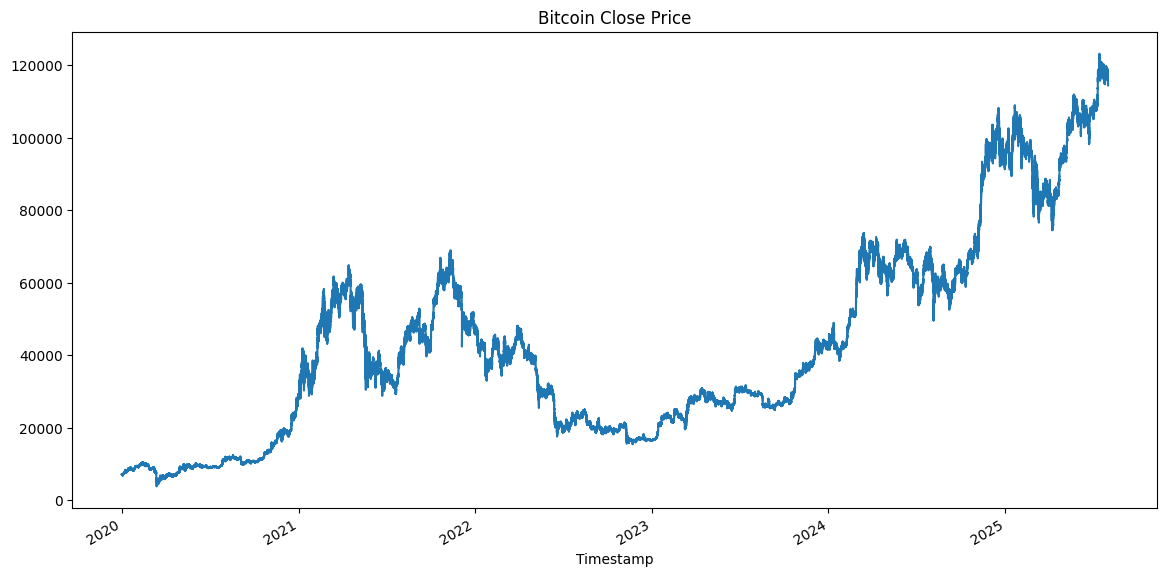

In [9]:
# import pandas as pd
# from datetime import datetime
# bitstamp = pd.read_csv("btcusd_1-min_data.csv")
# bitstamp.info()
# bitstamp['Timestamp'] = pd.to_datetime(bitstamp['Timestamp'], unit='s')
# bitstamp.set_index('Timestamp', inplace=True)
# bitstamp.tail()
%load_ext autoreload
%autoreload 2
import sys
import os

sys.path.append(os.path.abspath("../src"))
from preprocessing import *

# Load the data
bitstamp = dataload()

# Filter the data from 2020-01-01 to the last date available
bitstamp = data_filter(bitstamp, '2020-01-01', bitstamp.index[-1])

# Plotting the Close price
bitstamp.Close.plot(figsize=(14,7), title="Bitcoin Close Price")

Missing values in the dataset:
Missing timestamps: 1160
DatetimeIndex(['2025-03-15 00:01:00', '2025-03-15 00:02:00',
               '2025-03-15 00:03:00', '2025-03-15 00:04:00',
               '2025-03-15 00:05:00', '2025-03-15 00:06:00',
               '2025-03-15 00:07:00', '2025-03-15 00:08:00',
               '2025-03-15 00:09:00', '2025-03-15 00:10:00'],
              dtype='datetime64[ns]', freq='min')


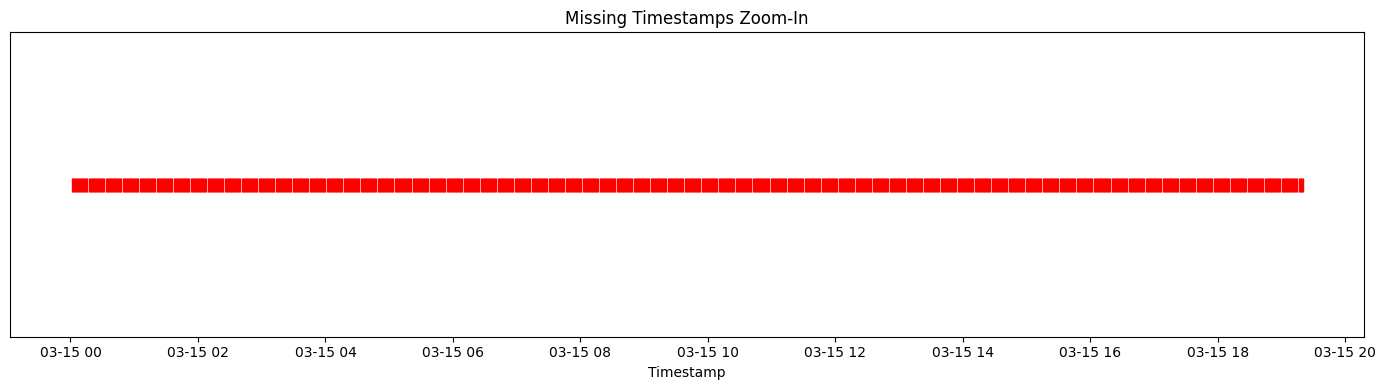

In [10]:
#calculating missing values in the dataset
import matplotlib.pyplot as plt

# find missing values by checking for NaN values
missing_values = bitstamp.isnull().sum()
missing_per = (missing_values/bitstamp.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

# display the missing values
print("Missing values in the dataset:")
expected_range = pd.date_range(start=bitstamp.index.min(), end=bitstamp.index.max(), freq='1min')
missing_times = expected_range.difference(bitstamp.index)
print("Missing timestamps:", len(missing_times))
print(missing_times[:10])

# Plotting the missing timestamps
missing_df = pd.DataFrame(index=missing_times)
missing_df['Missing'] = 1
plt.figure(figsize=(14, 4))
plt.plot(missing_df.index, missing_df['Missing'], '|', color='red', markersize=10)
plt.title("Missing Timestamps Zoom-In")
plt.xlabel("Timestamp")
plt.yticks([]) 
plt.tight_layout()
plt.show()

g:\ML\Project\src\preprocessing.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method=method)


Missing values in the dataset:
Missing timestamps: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='min')
                         Open      High       Low     Close    Volume
Timestamp                                                            
2025-08-01 00:55:00  115031.0  115180.0  115031.0  115077.0  4.551279
2025-08-01 00:56:00  115107.0  115258.0  115107.0  115258.0  4.916915
2025-08-01 00:57:00  115258.0  115271.0  115209.0  115271.0  0.950385
2025-08-01 00:58:00  115271.0  115410.0  115271.0  115410.0  5.030814
2025-08-01 00:59:00  115410.0  115464.0  115409.0  115425.0  2.373751


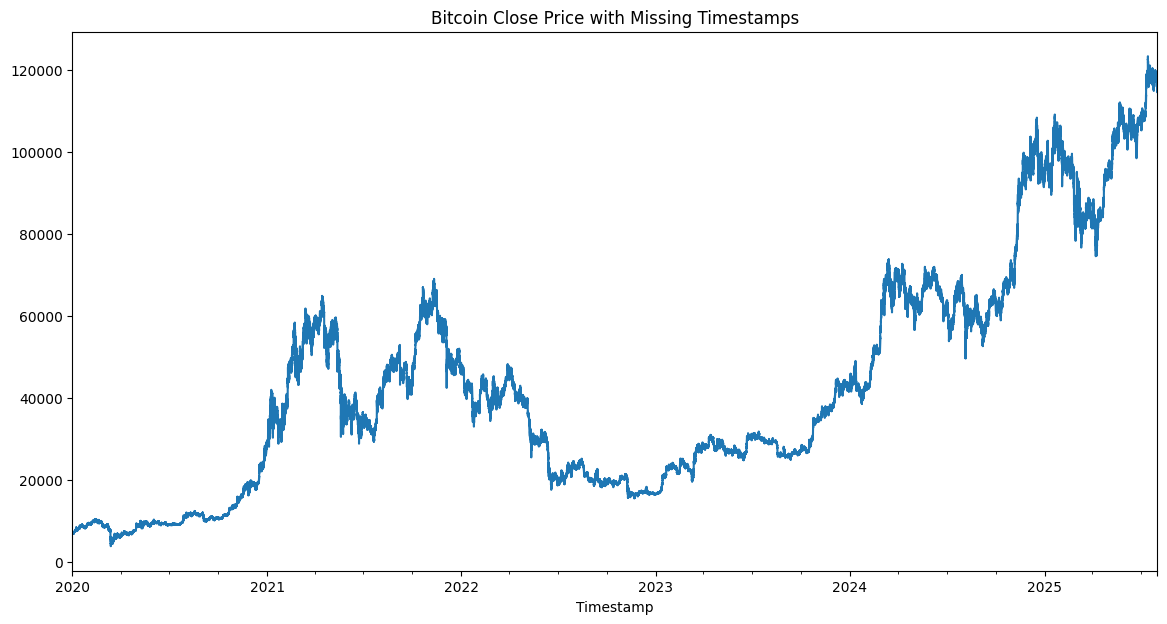

In [11]:

bitstamp_full = add_missing_timestamps(bitstamp, freq='1min')
# Plotting the Close price with missing timestamps
bitstamp_full['Close'].plot(figsize=(14, 7), title="Bitcoin Close Price with Missing Timestamps")

# using forward fill to fill the missing values
bitstamp_filled = fill_missing_values(bitstamp_full, method='ffill')

# display the missing values after filling
print("Missing values in the dataset:")
expected_range = pd.date_range(start=bitstamp_filled.index.min(), end=bitstamp_filled.index.max(), freq='1min')
missing_times = expected_range.difference(bitstamp_filled.index)
print("Missing timestamps:", len(missing_times))
print(missing_times[:10])
print(bitstamp_filled.tail())

<Figure size 1200x900 with 0 Axes>

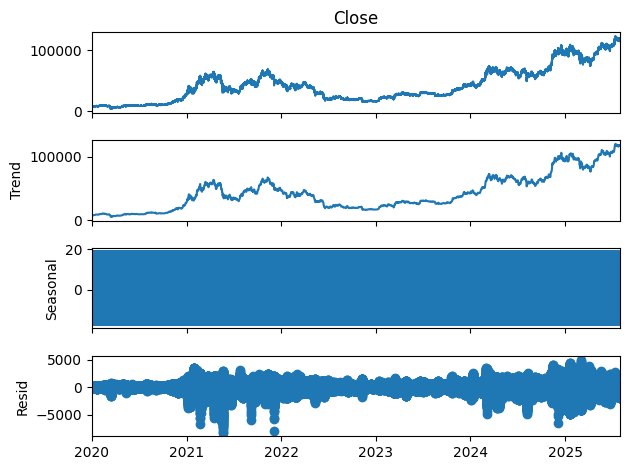

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts = bitstamp_filled['Close'].copy()

ts = ts.resample('1min').mean() 

decomp_result = seasonal_decompose(ts, model='additive', period=1440)  

trend = decomp_result.trend
seasonal = decomp_result.seasonal
residual = decomp_result.resid

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
decomp_result.plot()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from LSTM_train import create_sequences
import numpy as np

WINDOW_SIZE = 30
TRAIN_RATIO = 0.8
VAL_RATIO = 0.2   # 相对于训练集的

# ✅ 原始数据
df = bitstamp_filled.copy()
features = df[['Close', 'Volume']].values

# ✅ 时间顺序划分
n_total = len(features)
n_train = int(n_total * TRAIN_RATIO)

train_features = features[:n_train]
test_features = features[n_train:]

# ✅ 拟合 scaler 只用训练集
scaler = MinMaxScaler()
scaler.fit(train_features)

# ✅ 分别变换训练 / 测试
scaled_train = scaler.transform(train_features)
scaled_test = scaler.transform(test_features)


# ✅ 创建训练/测试序列
X_train_all, y_train_all = create_sequences(scaled_train, WINDOW_SIZE)
X_test, y_test = create_sequences(scaled_test, WINDOW_SIZE)

# ✅ 从训练集中进一步划分验证集
n_val = int(len(X_train_all) * VAL_RATIO)
X_val = X_train_all[-n_val:]
y_val = y_train_all[-n_val:]
X_train = X_train_all[:-n_val]
y_train = y_train_all[:-n_val]

print("Train scaled range:", X_train_all.min(), X_train_all.max())
print("Test scaled range:", X_test.min(), X_test.max())

Train scaled range: 0.0 1.0
Test scaled range: 0.0 1.707031417580689


In [ ]:
import csv
import json
from keras.callbacks import EarlyStopping
from LSTM_train import train_and_save_model, train_and_save_model_with_attention
import os

model_index = 12  # 当前是第11个模型
window_size = 30

model, history = train_and_save_model_with_attention(
    X_train, y_train,
    X_val, y_val,
    model_index=model_index,
    layers=1,
    units=64,
    dropout_rate=0.2,
    batch_size=32,
    epochs=40,
    window_size=window_size,
    callback = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True  ),
    result_file=os.path.join(os.getcwd(), "training_results.csv")
)

✅ Evaluating models/model_12_layers1_units64_with_attention.h5 ...
18351/18351 [==============================] - 30s 2ms/step


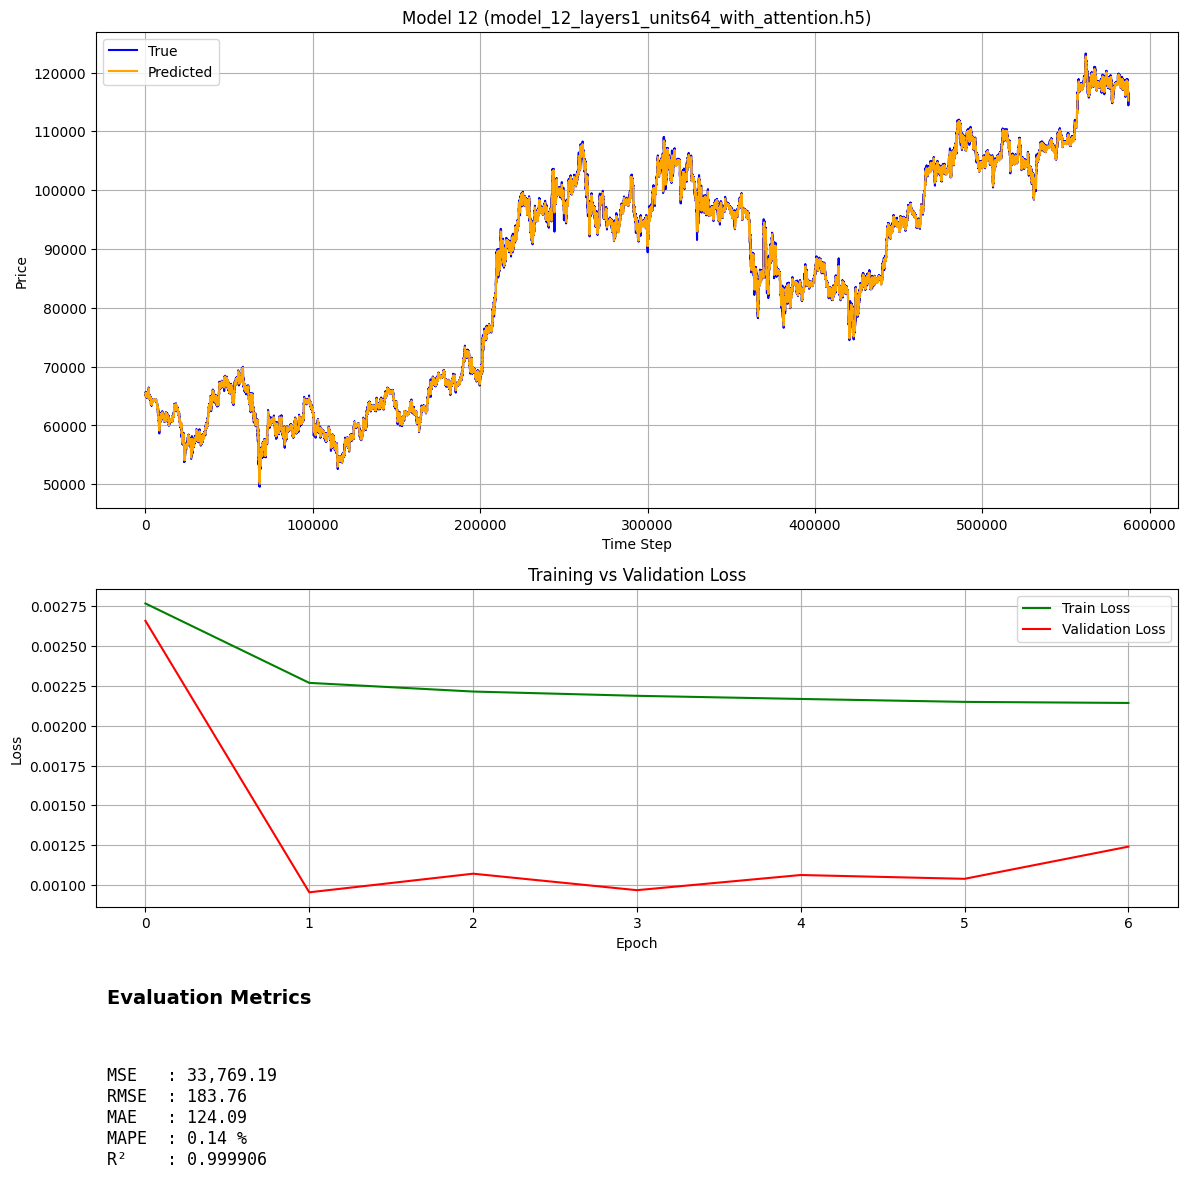

In [46]:
from LSTM_train import evaluate_model,evaluate_model_multistep

df = pd.read_csv("training_results.csv")
df.set_index("index", inplace=True)  # 用 CSV 中的 'index' 列作为 DataFrame 索引

target_indices = [12]

results = []
for i in target_indices:
    if i not in df.index:
        print(f"❌ index {i} 不在 CSV 中，跳过")
        continue

    row = df.loc[i]  # 用显式 index 查找行
    model_path = f"models/{row['model_name']}"
    history_path = f"histories/{row['history_path']}"
    print(f"✅ Evaluating {model_path} ...")
    
    result = evaluate_model(
        model_path=model_path,
        history_path=history_path,
        X_test=X_test,
        y_test=y_test,
        scaler=scaler,
        title=f"Model {i} ({row['model_name']})",
        attention=True
    )
    results.append(result)


['lstm_units', 'num_layers', 'dropout', 'batch_size', 'epochs', 'optimizer', 'model_name', 'val_loss', 'history_path']
Evaluating models/model_0_layers1_units64.h5 ...
18352/18352 [==============================] - 28s 1ms/step


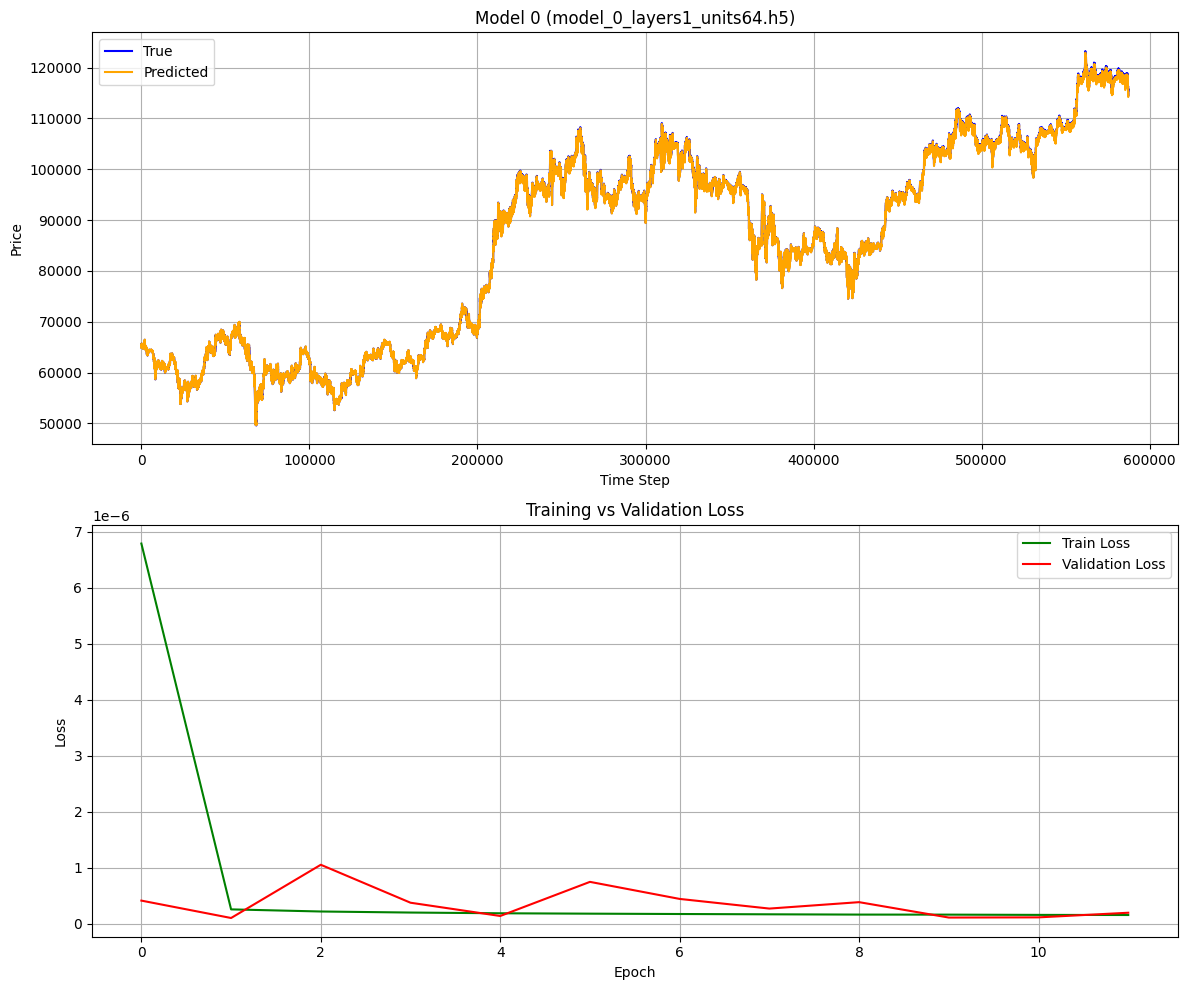

Model: models/model_0_layers1_units64.h5
MSE:  14542.159911
RMSE: 120.590878
MAE:  88.652173
R²:   0.999960
Evaluating models/model_1_layers1_units128.h5 ...
18352/18352 [==============================] - 29s 2ms/step


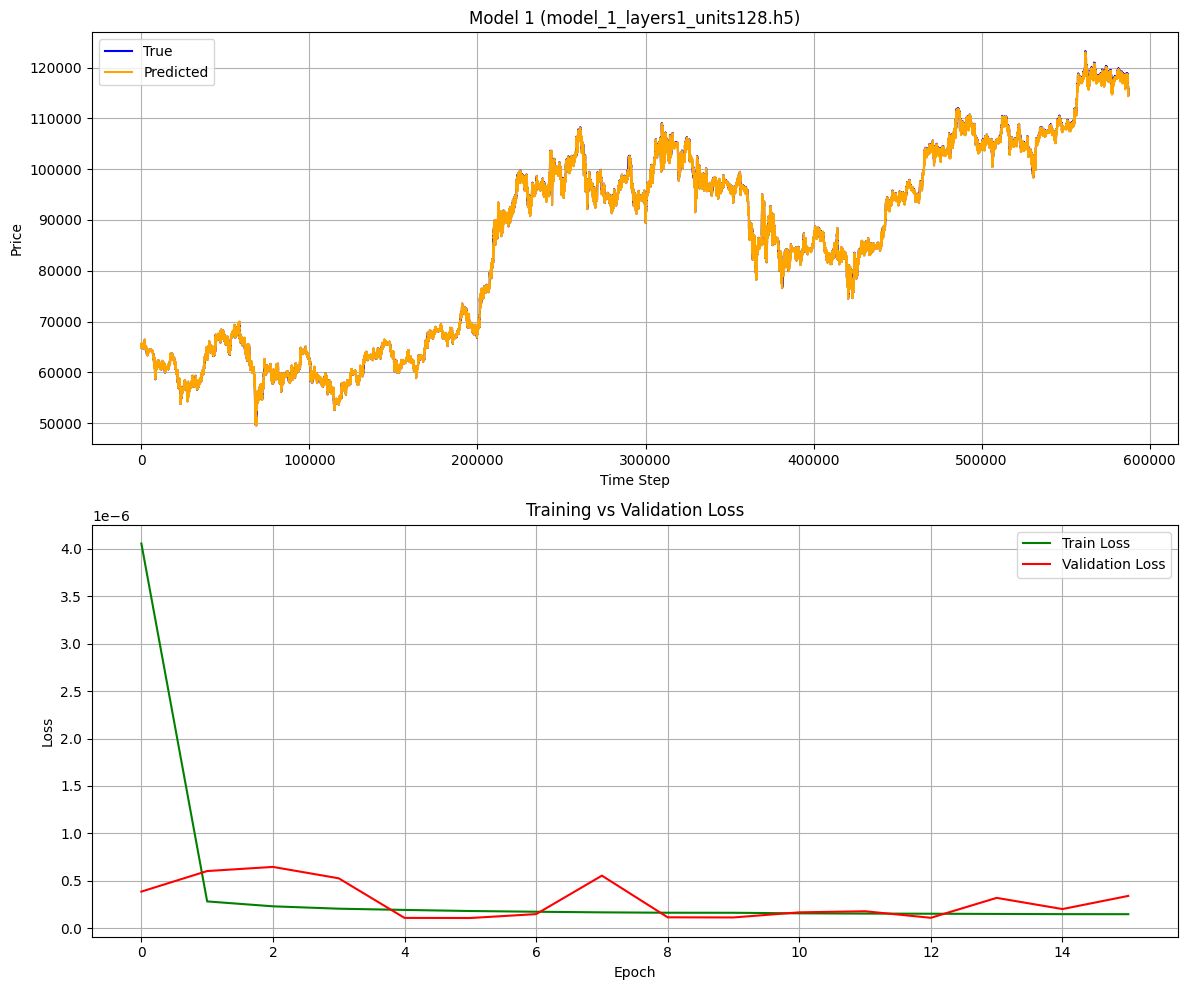

Model: models/model_1_layers1_units128.h5
MSE:  6993.538621
RMSE: 83.627380
MAE:  60.838859
R²:   0.999981
Evaluating models/model_2_layers2_units128.h5 ...
18352/18352 [==============================] - 43s 2ms/step


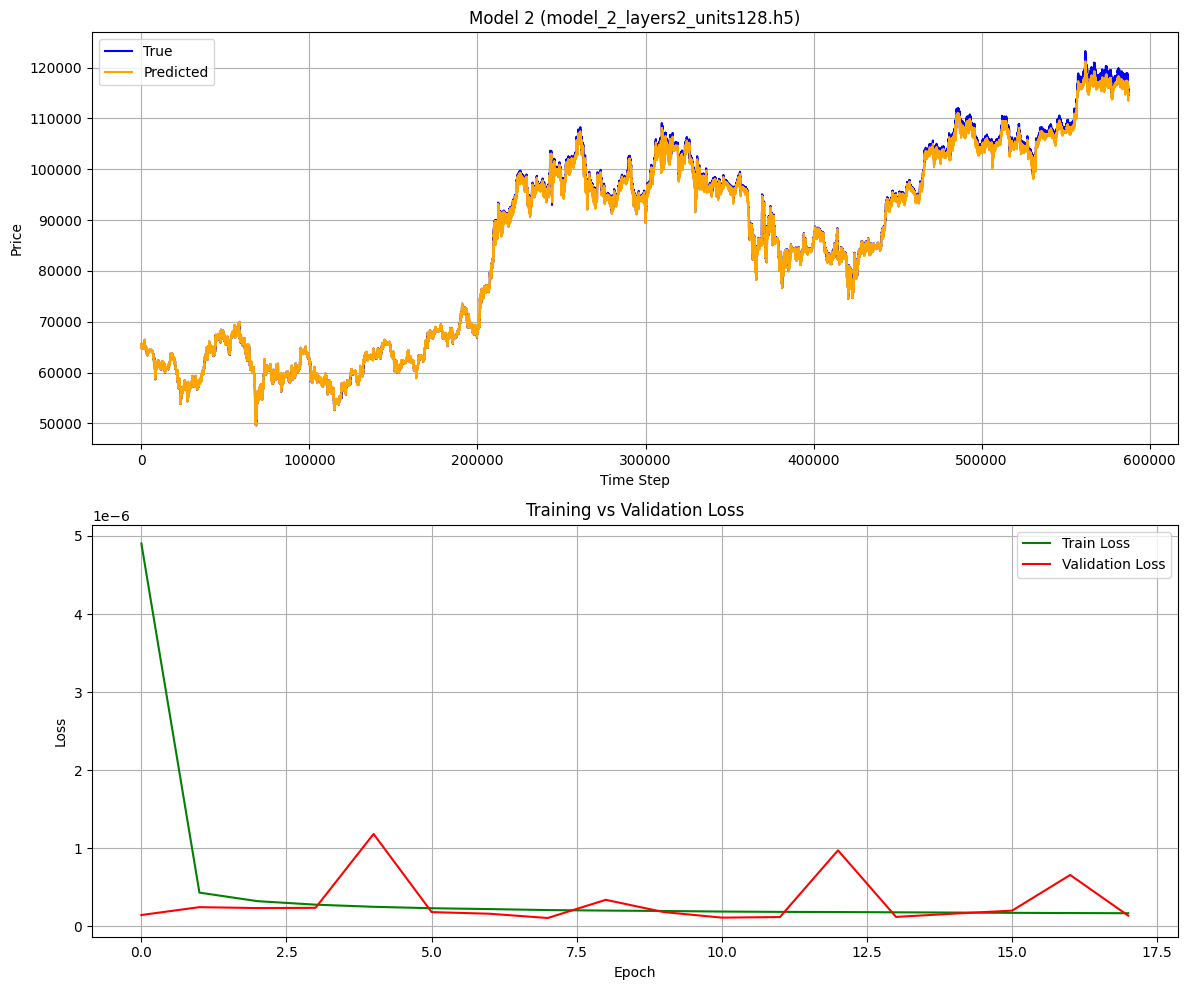

Model: models/model_2_layers2_units128.h5
MSE:  220501.641310
RMSE: 469.576023
MAE:  305.772139
R²:   0.999387
Evaluating models/model_3_layers2_units64.h5 ...
18352/18352 [==============================] - 40s 2ms/step


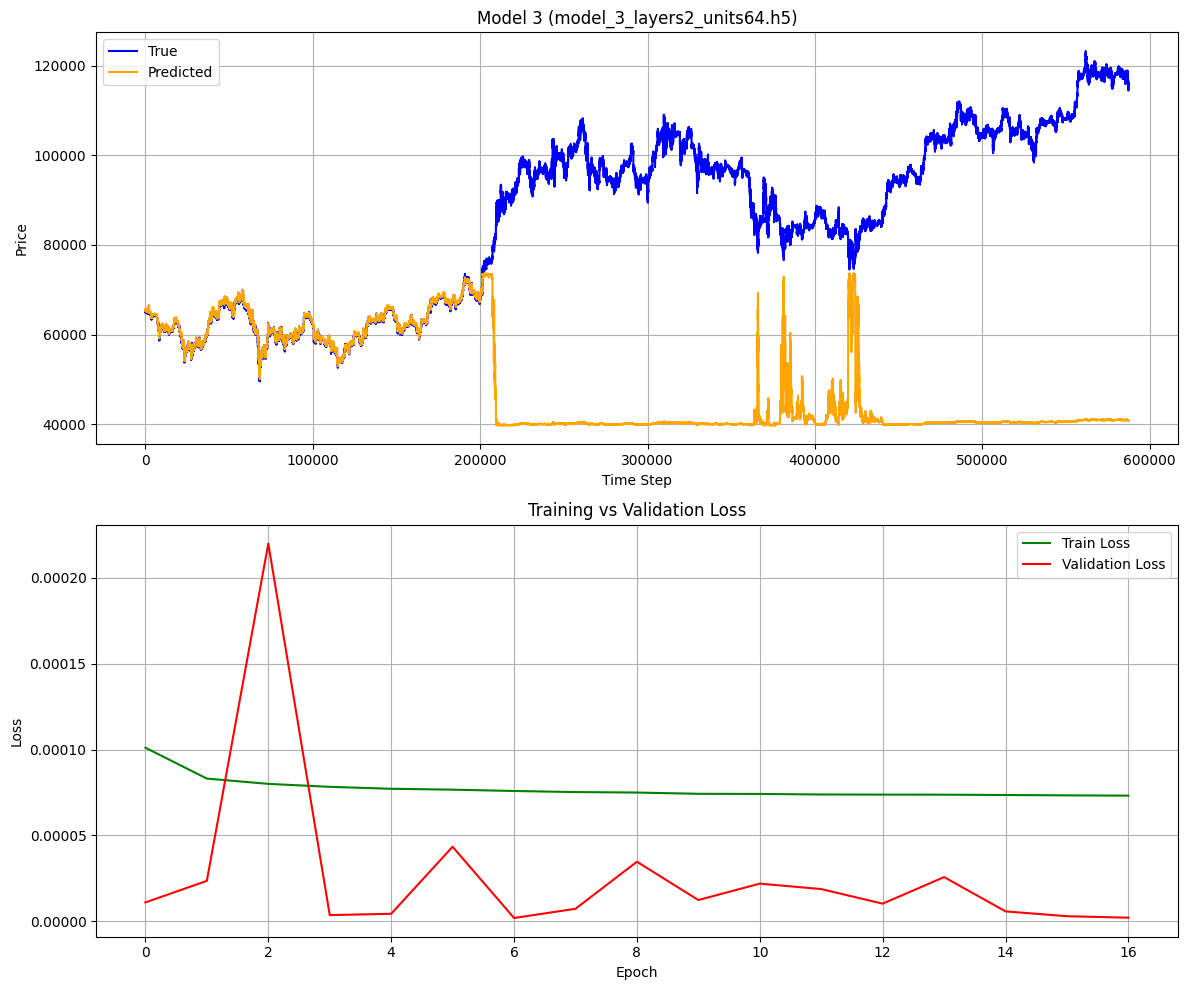

Model: models/model_3_layers2_units64.h5
MSE:  2201634230.828090
RMSE: 46921.575323
MAE:  36997.657206
R²:   -5.120138
Evaluating models/model_4_layers2_units64.h5 ...
18352/18352 [==============================] - 42s 2ms/step


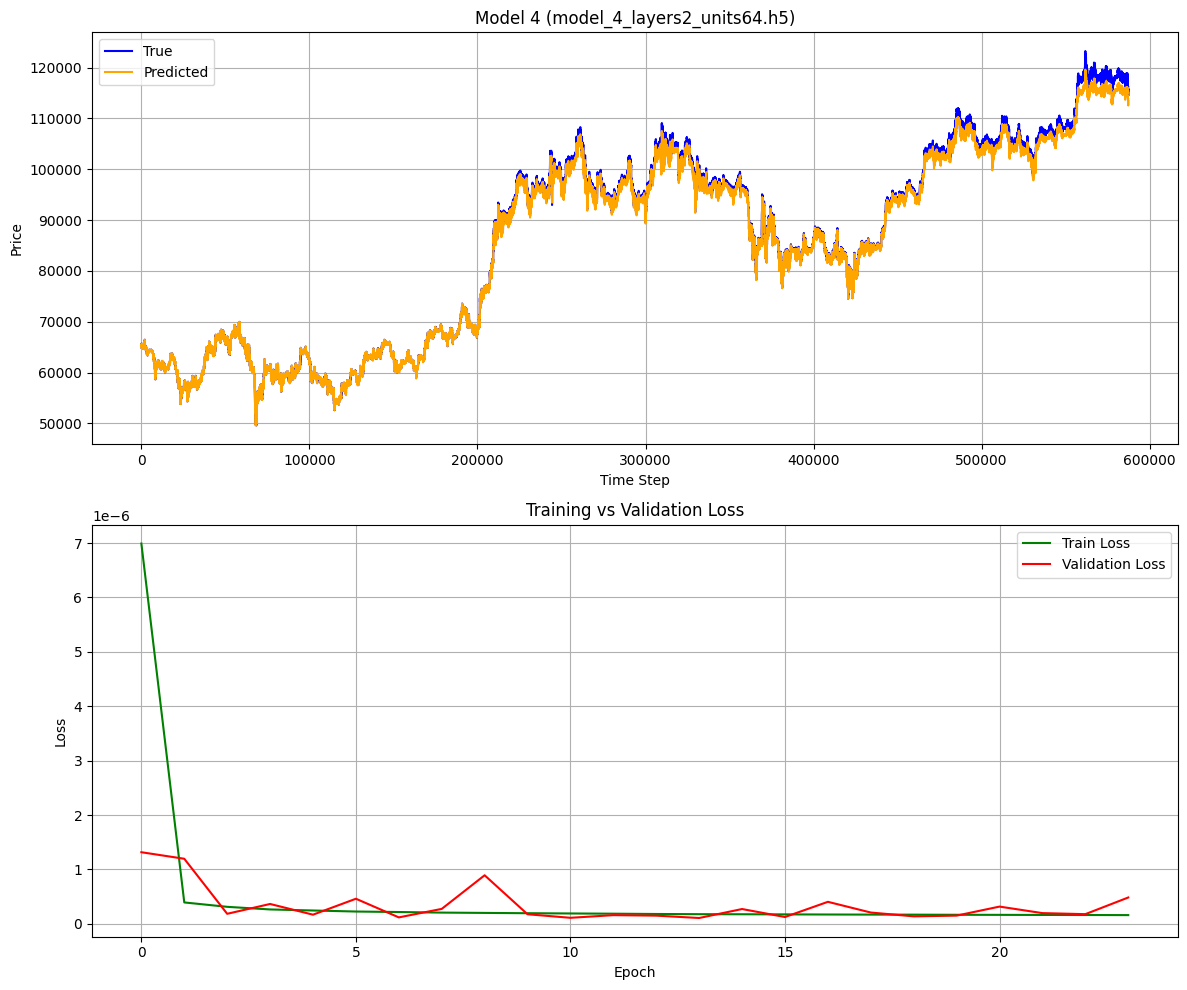

Model: models/model_4_layers2_units64.h5
MSE:  710167.355809
RMSE: 842.714279
MAE:  533.770814
R²:   0.998026


In [ ]:
window_size = 24  # ← 原模型训练用的

X, y = create_sequences(scaled_data, window_size=window_size)

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Optional validation set（如果你要用）
val_split = int(len(X_train) * 0.8)
X_val, y_val = X_train[val_split:], y_train[val_split:]
X_train_part, y_train_part = X_train[:val_split], y_train[:val_split]

df = pd.read_csv("training_results.csv")
print(df.columns.tolist())
target_indices = [0,1,2,3,4]  # model_0, model_6, model_7

results = []
for i in target_indices:
    row = df.iloc[i]
    model_path = f"models/{row['model_name']}"
    history_path = f"histories/{row['history_path']}"
    print(f"Evaluating {model_path} ...")
    
    result = evaluate_model(
        model_path=model_path,
        history_path=history_path,
        X_test=X_test,
        y_test=y_test,
        scaler=scaler,
        title=f"Model {i} ({row['model_name']})"
    )
    results.append(result)


In [ ]:

from LSTM_train import build_and_train_model
from itertools import product
import random
import time
import pandas as pd

param_grid = {
    'lstm_units': [64, 128],
    'num_layers': [1, 2],
    'dropout': [0.0, 0.2],
    'batch_size': [32],
    'epochs': [80],
    'optimizer': ['adam']
}

# ✅ 6. 创建保存目录
os.makedirs("models", exist_ok=True)
os.makedirs("histories", exist_ok=True)

# ✅ 7. 随机选一部分组合（避免炸卡）
combinations = list(product(*param_grid.values()))
keys = list(param_grid.keys())
combinations = random.sample(combinations, min(5, len(combinations)))  # 最多跑5组

# ✅ 8. 保存每个模型的配置和结果
results = []

for i, combo in enumerate(combinations):
    config = dict(zip(keys, combo))
    print(f"\n🚀 Running config {i+1}/{len(combinations)}: {config}")

    model, history = build_and_train_model(
        X_train_part, y_train_part,
        X_val, y_val,
        **config
    )

    # 保存模型和历史记录
    model_name = f"model_{i}_layers{config['num_layers']}_units{config['lstm_units']}.h5"
    history_name = f"history_{i}.json"
    model.save(os.path.join("models", model_name))
    with open(os.path.join("histories", history_name), "w") as f:
        json.dump(history.history, f)

    # 保存 val_loss 最小值
    best_val_loss = min(history.history['val_loss'])
    results.append({**config, 'model_name': model_name, 'val_loss': best_val_loss})

    print(f"✅ Saved {model_name} with val_loss={best_val_loss:.6f}")

    time.sleep(5)  # 稍微冷却防止过热

# ✅ 9. 保存结果为 CSV
results_df = pd.DataFrame(results)
results_df.to_csv("training_results.csv", index=False)
print("📄 All results saved to training_results.csv")


In [ ]:
import numpy as np

def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :])  
        y.append(data[i + window_size, 0])    
    return np.array(X), np.array(y)


scaled_data = df[['Close_scaled', 'Volume_scaled']].values

X, y = create_sequences(scaled_data, window_size=24)

print(X.shape)  # 例如：(n_samples, 24, 2)
print(y.shape)  # 例如：(n_samples,)


split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, input_shape=(24, 2)))  
model.add(Dense(1)) 

model.compile(optimizer='adam', loss='mse')
model.summary()


model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


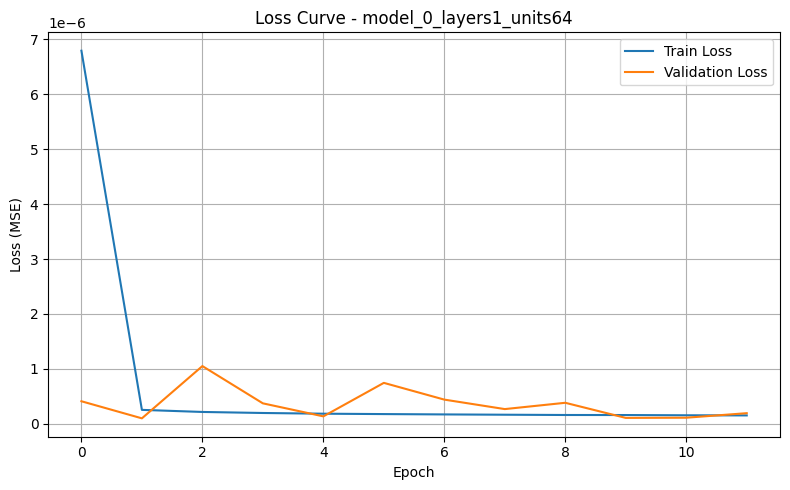

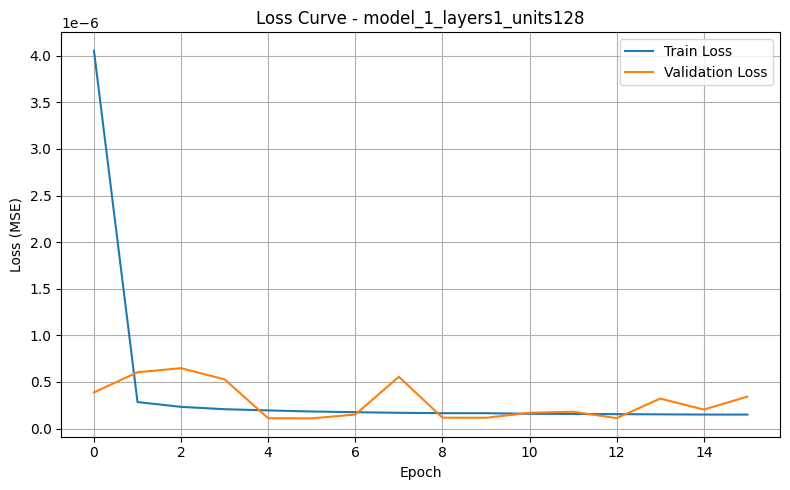

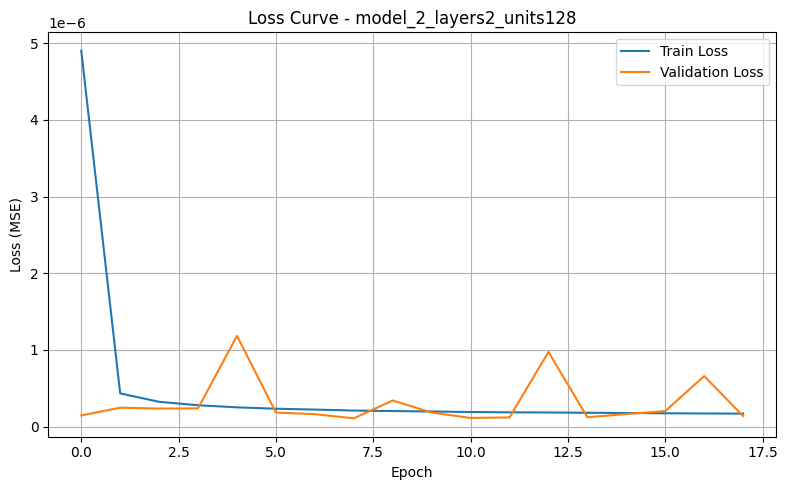

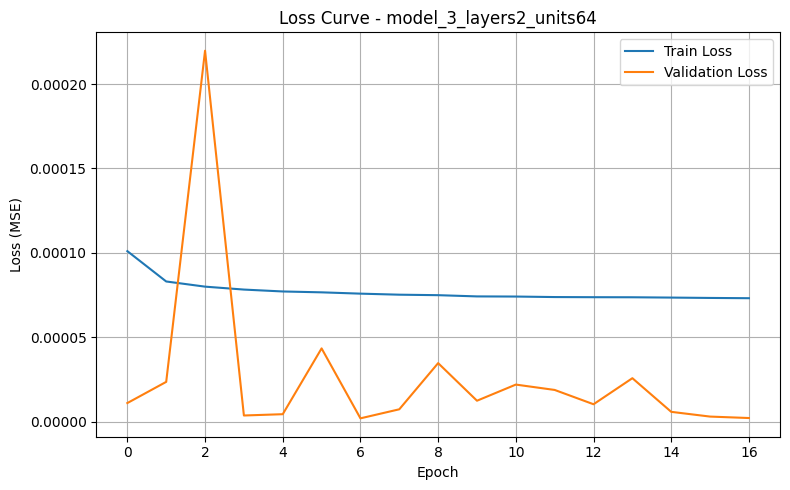

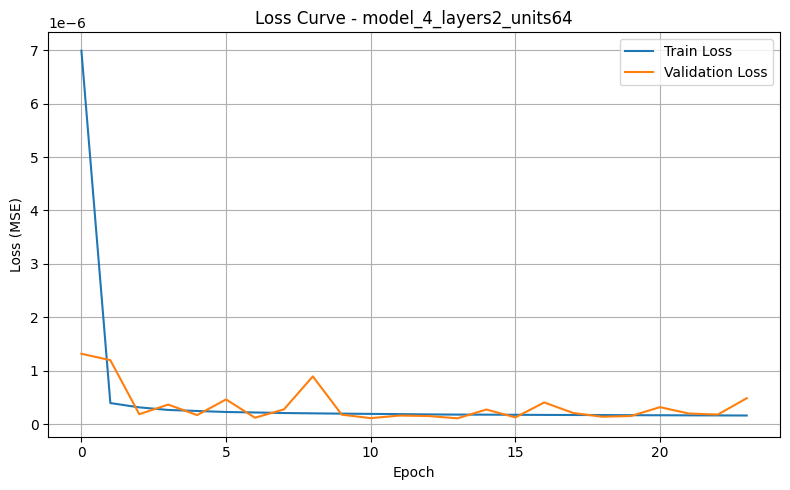

In [ ]:
import os
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 构造数据
scaled_data = df[['Close_scaled', 'Volume_scaled']].values

def create_sequences(data, window_size=24):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :])
        y.append(data[i + window_size, 0])  # Close 作为目标
    return np.array(X), np.array(y)

window_size = 24
X, y = create_sequences(scaled_data, window_size=window_size)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 遍历所有模型文件
model_files = sorted(glob.glob("models/*.h5"))
results = []

# for model_path in model_files:
#     model = load_model(model_path)
#     model_name = os.path.basename(model_path).replace(".h5", "")

#     # 模型预测
#     y_pred = model.predict(X_test).flatten()

#     # 评估指标
#     mse = mean_squared_error(y_test, y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)

#     # 尝试加载对应的训练历史
#     hist_path = model_path.replace("models", "histories").replace(".h5", ".json")
#     val_loss_curve, train_loss_curve = None, None
#     if os.path.exists(hist_path):
#         with open(hist_path, "r") as f:
#             history_dict = json.load(f)
#             train_loss_curve = history_dict.get("loss", [])
#             val_loss_curve = history_dict.get("val_loss", [])
#             min_val_loss = min(val_loss_curve) if val_loss_curve else None
#     else:
#         min_val_loss = None

#     # 保存结果
#     results.append({
#         "Model": model_name,
#         "MSE": mse,
#         "RMSE": rmse,
#         "MAE": mae,
#         "R2": r2,
#         "Min Val Loss": min_val_loss,
#     })

#     # 绘图
    

# # 打印汇总表格
# results_df = pd.DataFrame(results)
# results_df = results_df.sort_values(by="RMSE")
# print(results_df)

history_files = sorted(glob.glob("histories/history_*.json"))
model_files = sorted(glob.glob("models/model_*.h5"))  # 只为了获取模型名

# 确保数量一致
assert len(history_files) == len(model_files), "模型和历史文件数量不一致"

# 遍历所有 history 文件
for i, (hist_path, model_path) in enumerate(zip(history_files, model_files)):
    with open(hist_path, "r") as f:
        history = json.load(f)

    loss = history.get("loss", [])
    val_loss = history.get("val_loss", [])
    model_name = os.path.basename(model_path).replace(".h5", "")

    # 画 loss 曲线
    plt.figure(figsize=(8, 5))
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f"Loss Curve - {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



C:\Users\jiang\AppData\Local\Temp\ipykernel_33240\539180010.py:17: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiang\AppData\Local\Temp\ipykernel_33240\539180010.py:17: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiang\AppData\Local\Temp\ipykernel_33240\539180010.py:17: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiang\AppData\Local\Temp\ipykernel_33240\539180010.py:17: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\jiang\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jiang\miniconda3\envs\tf-gpu\lib\site-packages\IP

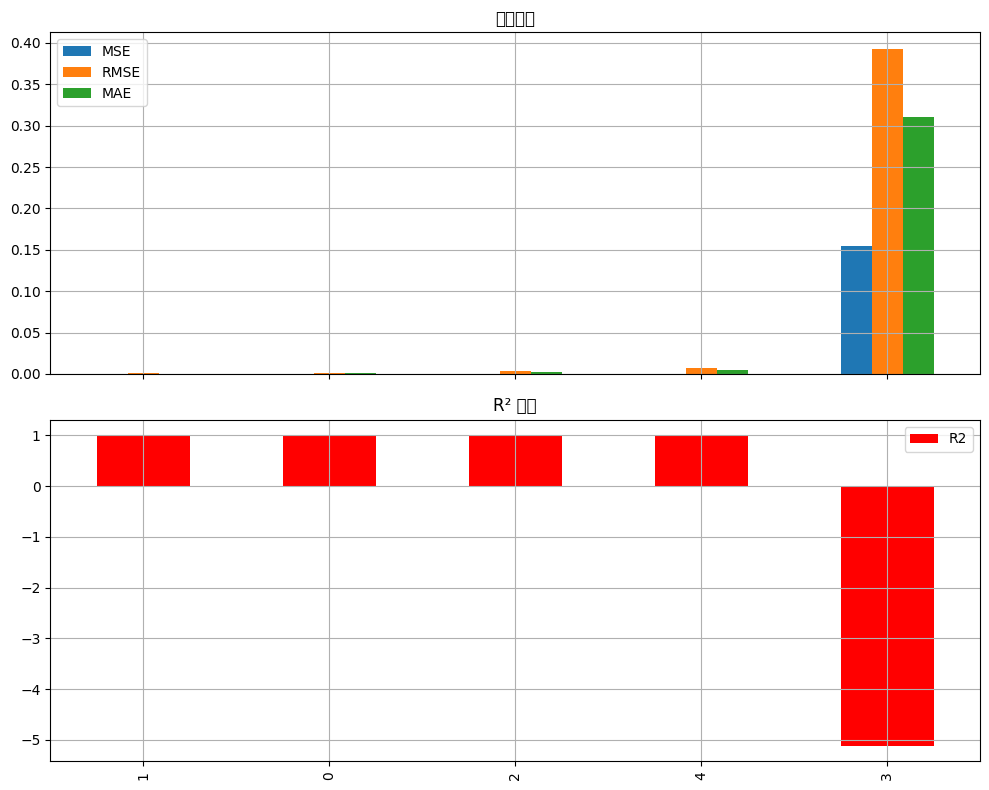

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# 第一张图：MSE, RMSE, MAE
results_df[['MSE', 'RMSE', 'MAE']].plot(kind='bar', ax=axs[0])
axs[0].set_title("误差指标")
axs[0].legend()
axs[0].grid(True)

# 第二张图：R²
results_df[['R2']].plot(kind='bar', color='red', ax=axs[1])
axs[1].set_title("R² 指标")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


## double layer LSTM

In [ ]:
import os
import json
import csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



# Add time feature

In [ ]:
# Extracting time features from the index

df['year'] = df.index.year
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['day'] = df.index.day
df['month'] = df.index.month
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
print(df[['year', 'hour', 'dayofweek', 'day', 'month', 'is_weekend']].tail(100))



                     year  hour  dayofweek  day  month  is_weekend
Timestamp                                                         
2025-07-31 23:20:00  2025    23          3   31      7           0
2025-07-31 23:21:00  2025    23          3   31      7           0
2025-07-31 23:22:00  2025    23          3   31      7           0
2025-07-31 23:23:00  2025    23          3   31      7           0
2025-07-31 23:24:00  2025    23          3   31      7           0
...                   ...   ...        ...  ...    ...         ...
2025-08-01 00:55:00  2025     0          4    1      8           0
2025-08-01 00:56:00  2025     0          4    1      8           0
2025-08-01 00:57:00  2025     0          4    1      8           0
2025-08-01 00:58:00  2025     0          4    1      8           0
2025-08-01 00:59:00  2025     0          4    1      8           0

[100 rows x 6 columns]


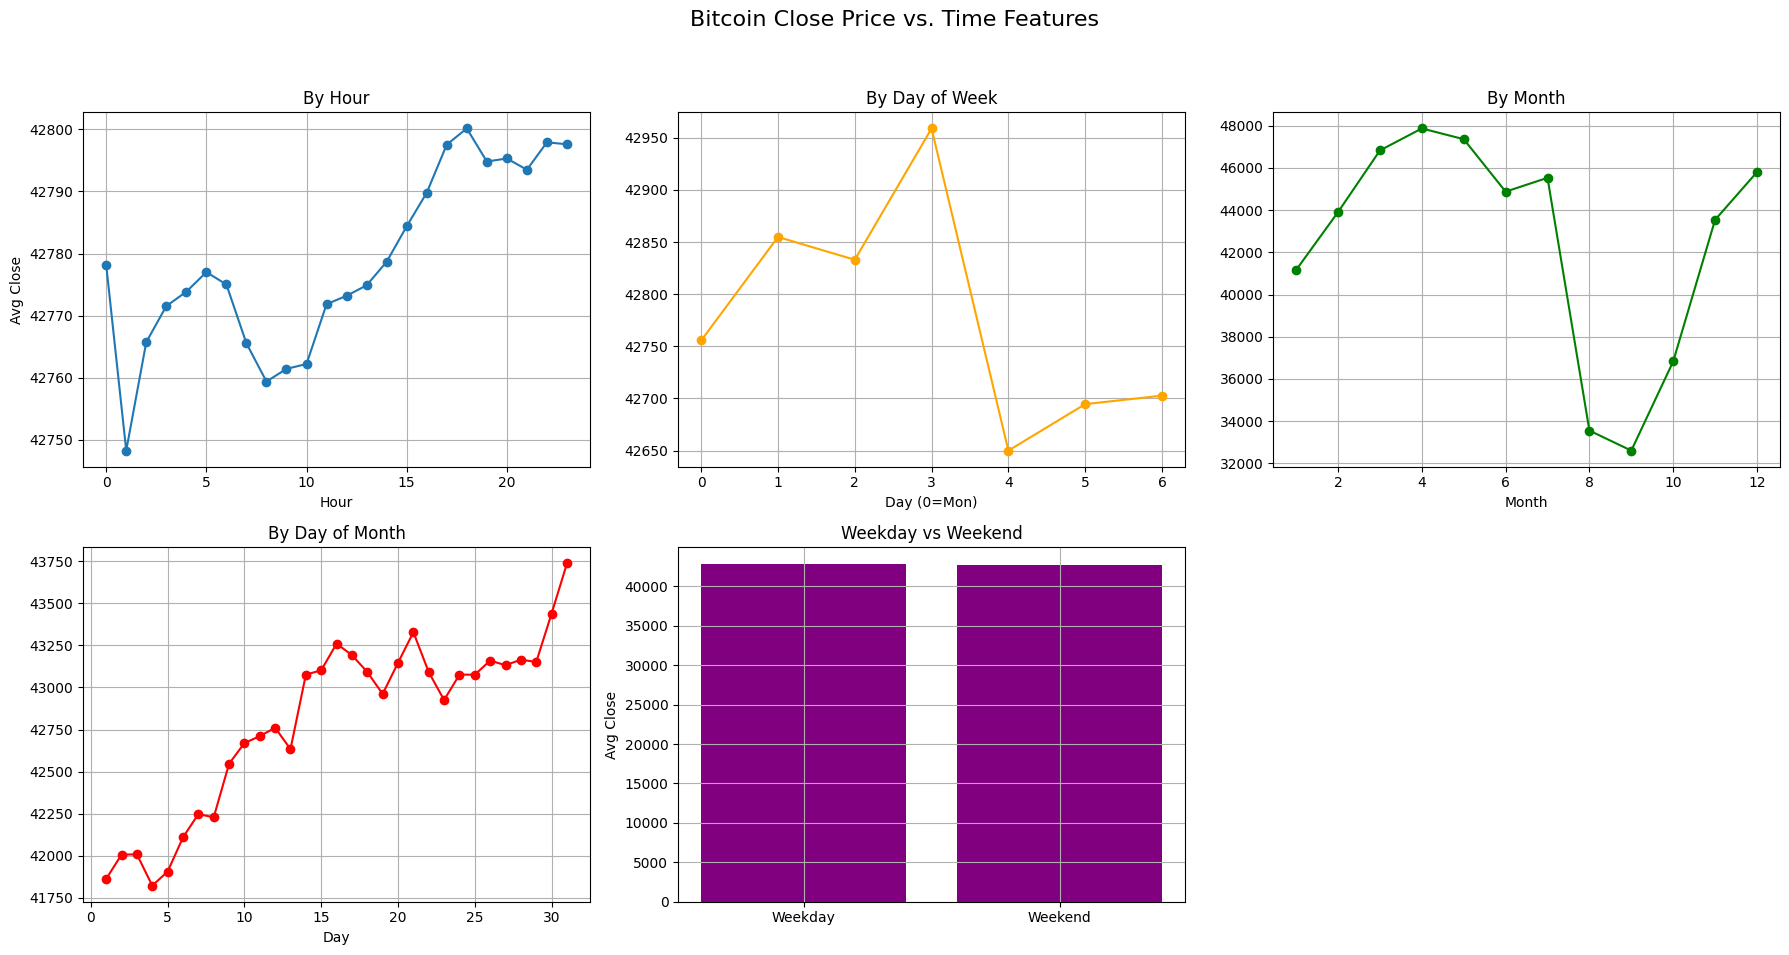

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # 总共 6 个图
fig.suptitle("Bitcoin Close Price vs. Time Features", fontsize=16)

# Hour
hour_avg = df.groupby('hour')['Close'].mean()
axes[0, 0].plot(hour_avg, marker='o')
axes[0, 0].set_title('By Hour')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Avg Close')
axes[0, 0].grid(True)

# Day of Week
dow_avg = df.groupby('dayofweek')['Close'].mean()
axes[0, 1].plot(dow_avg, marker='o', color='orange')
axes[0, 1].set_title('By Day of Week')
axes[0, 1].set_xlabel('Day (0=Mon)')
axes[0, 1].grid(True)

# Month
month_avg = df.groupby('month')['Close'].mean()
axes[0, 2].plot(month_avg, marker='o', color='green')
axes[0, 2].set_title('By Month')
axes[0, 2].set_xlabel('Month')
axes[0, 2].grid(True)

# Day of Month
day_avg = df.groupby('day')['Close'].mean()
axes[1, 0].plot(day_avg, marker='o', color='red')
axes[1, 0].set_title('By Day of Month')
axes[1, 0].set_xlabel('Day')
axes[1, 0].grid(True)

# Is Weekend
weekend_avg = df.groupby('is_weekend')['Close'].mean()
axes[1, 1].bar(['Weekday', 'Weekend'], weekend_avg.values, color='purple')
axes[1, 1].set_title('Weekday vs Weekend')
axes[1, 1].set_ylabel('Avg Close')
axes[1, 1].grid(True)


axes[1, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

count    2.936220e+06
mean     2.385076e-16
std      1.000000e+00
min     -1.397077e+00
25%     -7.881414e-01
50%     -2.019005e-01
75%      6.253166e-01
max      2.888576e+00
Name: close_z_global, dtype: float64
hour
0    -1.718126e-05
1    -1.090465e-03
2    -4.638170e-04
3    -2.555406e-04
4    -1.723894e-04
5    -5.918896e-05
6    -1.304431e-04
7    -4.707638e-04
8    -6.912455e-04
9    -6.180280e-04
10   -5.900069e-04
11   -2.442018e-04
12   -1.959244e-04
13   -1.353177e-04
14    6.913029e-07
15    2.056139e-04
16    3.993966e-04
17    6.774929e-04
18    7.710530e-04
19    5.799779e-04
20    5.975039e-04
21    5.323520e-04
22    6.907842e-04
23    6.796568e-04
Name: close_z_global, dtype: float64


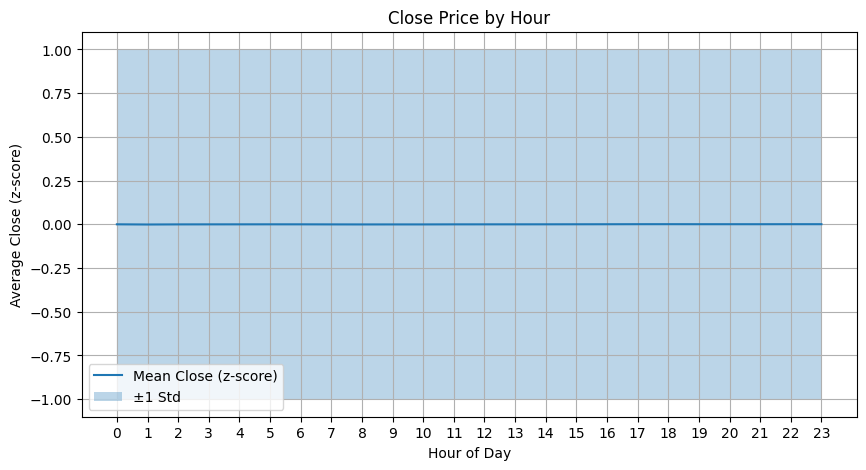

In [ ]:
import matplotlib.pyplot as plt

df['date'] = df.index.date 
df['close_z'] = df.groupby('date')['Close'].transform(lambda x: (x - x.mean()) / x.std())
global_mean = df['Close'].mean()
global_std = df['Close'].std()
df['close_z_global'] = (df['Close'] - global_mean) / global_std

hour_stats = df.groupby('hour')['close_z_global'].agg(['mean', 'std'])

hour_stats['upper'] = hour_stats['mean'] + hour_stats['std']
hour_stats['lower'] = hour_stats['mean'] - hour_stats['std']
print(df['close_z_global'].describe())
print(df.groupby('hour')['close_z_global'].mean())

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(hour_stats.index, hour_stats['mean'], label='Mean Close (z-score)')
plt.fill_between(hour_stats.index, hour_stats['lower'], hour_stats['upper'], alpha=0.3, label='±1 Std')
plt.title("Close Price by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Close (z-score)")
plt.grid(True)
plt.legend()
plt.xticks(range(0, 24))
plt.show()

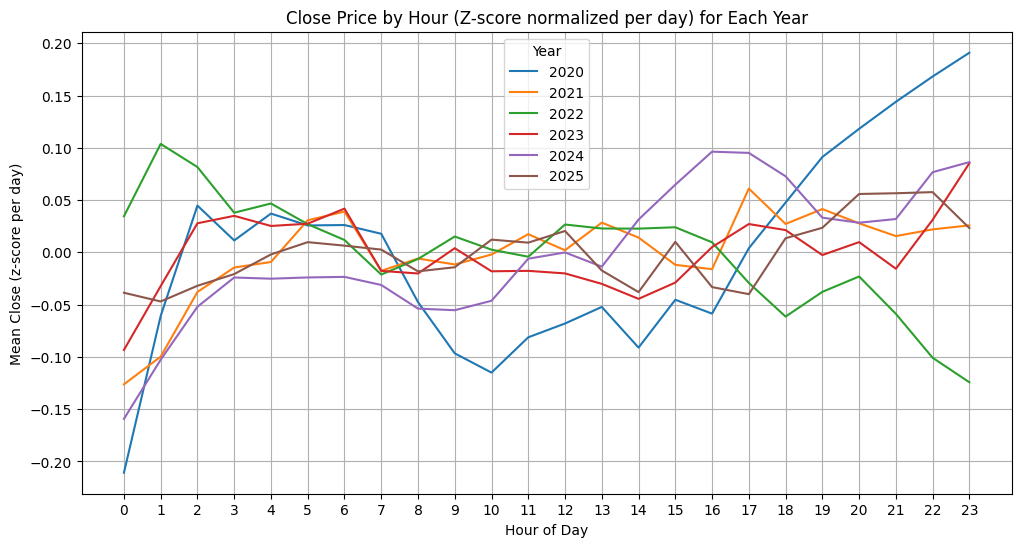

In [ ]:
grouped = df.groupby(['year', 'hour'])['close_z'].mean().reset_index()

plt.figure(figsize=(12, 6))
for year in sorted(grouped['year'].unique()):
    subset = grouped[grouped['year'] == year]
    plt.plot(subset['hour'], subset['close_z'], label=f'{year}')

plt.title("Close Price by Hour (Z-score normalized per day) for Each Year")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Close (z-score per day)")
plt.grid(True)
plt.legend(title="Year")
plt.xticks(range(0, 24))
plt.show()

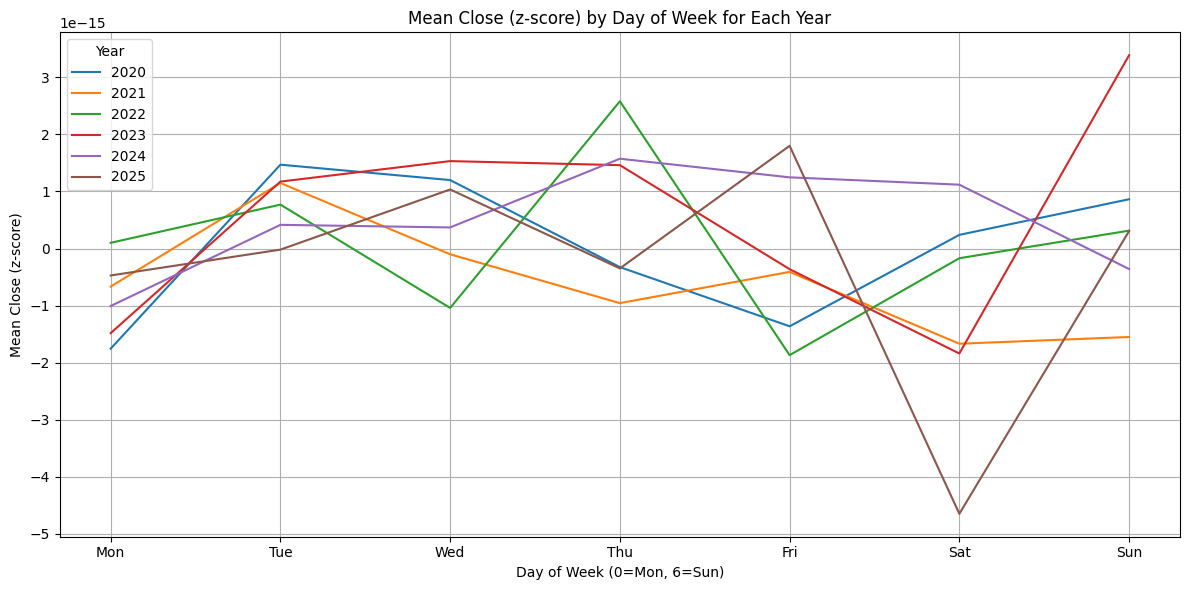

In [ ]:
dow_yearly = df.groupby(['year', 'dayofweek'])['close_z'].mean().unstack(level=0)


plt.figure(figsize=(12, 6))
for year in dow_yearly.columns:
    plt.plot(dow_yearly.index, dow_yearly[year], label=str(year))

plt.title("Mean Close (z-score) by Day of Week for Each Year")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Mean Close (z-score)")
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import os
import sys
print(python_version := sys.version)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:42:04) [MSC v.1943 64 bit (AMD64)]
Num GPUs Available:  1
